In [1]:
import numpy as np

import scipy.io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

np.set_printoptions(precision=2,
                       threshold=100000,
                       linewidth=100,suppress='True')

# Enable matplotlib inline plotting in ipython notebook
%matplotlib inline

# Enable autoreload of external modules
%load_ext autoreload
%autoreload 2

# Load in the data
mat = scipy.io.loadmat('Mouse_Brain2013.mat')

# Number of rows
y_size = np.int32(mat['y_size'][0][0])
# Number of columns
x_size = np.int32(mat['x_size'][0][0])
# Number of total pixels
nb_pixels = y_size * x_size
# Number of bins
feat_size = len(mat['mz_values'][0])

# mapping from pixel index to row-col
row2grid = mat.get('row2grid')
# Baseline normalised non-zero pixels
ims_bn = mat.get('ims_bn')
data=np.transpose(ims_bn)
# Number of nonzero pixels
nb_nonzero_pix = ims_bn.shape[1]
# List of booleans telling if the pixel is zero or not
nonnull_spots  = mat['nonnull_spots']





def get_img(data, bin_nb):
    """
    Generate an image from a specific mz bin in the MSI dataset.
    The data rows have to correspond to pixels.
    The data columns have to correspond to mz bins.
    """
    img = np.ndarray(shape=(y_size, x_size), dtype=float)
    nonzero_pix_idx = 0
    for pix_idx in xrange(nb_pixels):
        y, x = row2grid[pix_idx] - 1
        if nonnull_spots[pix_idx]:
            img[x,y] = data[nonzero_pix_idx, bin_nb]
            nonzero_pix_idx += 1
        else:
            img[x,y] = 0.0
    return img

def get_label_img(data):
       
    img = np.ndarray(shape=(y_size, x_size), dtype=float)
    nonzero_pix_idx = 0
    for pix_idx in xrange(nb_pixels):
        y, x = row2grid[pix_idx] - 1
        if nonnull_spots[pix_idx]:
            img[x,y] = data[nonzero_pix_idx]
            nonzero_pix_idx += 1
        else:
            img[x,y] = 0.0
    return img

data= data/np.max(data)
print 'ok'

ok


In [ ]:
import os
import sys
import time

import numpy

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


aant_comp=50
wfactor=25
regw=0.01
regb=0.01
train_epochs=200
learning_r=0.1
lr_decay=0.01



# start-snippet-1
class dA(object):
    
    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        input=None,
        n_visible=6490,
        n_hidden=aant_comp,
        W=None,
        bhid=None,
        bvis=None,
    ):
        
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        # note : W' was written as `W_prime` and b' as `b_prime`
        if not W:
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=wfactor * (-4) * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=wfactor * 4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)
            
        
        
        if not bvis:
            bvis = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.theano_rng = theano_rng       
        self.x = input
        
        self.params = [self.W, self.b, self.b_prime]
    # end-snippet-1

    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.nnet.sigmoid(   (T.dot(input, self.W) + self.b)  )

    def get_reconstructed_input(self, hidden):
        """Computes the reconstructed input given the values of the
        hidden layer

        """
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """ This function computes the cost and the updates for one trainng
        step of the dA """

        tilde_x=self.x
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        # note : we sum over the size of a datapoint; if we are using
        #        minibatches, L will be a vector, with one entry per
        #        example in minibatch
        L1 = (  - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)  )
        
        L2=regw * T.sum(abs(self.W)) + regb * T.sum(abs(self.b))
                       
        L= L1 + L2
        
        cost1=T.mean(L1)
        
        
       
        
        # note : L is now a vector, where each element is the
        #        cross-entropy cost of the reconstruction of the
        #        corresponding example of the minibatch. We need to
        #        compute the average of all these to get the cost of
        #        the minibatch
        cost = T.mean(L)

        # compute the gradients of the cost of the `dA` with respect
        # to its parameters
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
            
            
        ]
        
        return (cost1, updates)


def test_dA(training_epochs=train_epochs,
            dataset=data,
            batch_size=10):

    
    train_set_x=data
    train_set_x=theano.shared( train_set_x)
    
    # compute number of minibatches for training, validation and testing
    n_train_batches = (train_set_x.get_value(borrow=True).shape[0] / batch_size )
    print n_train_batches
    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    learning_rate = T.scalar('lr')
    ####################################
    # BUILDING THE MODEL NO CORRUPTION #
    ####################################

    rng = numpy.random.RandomState(125)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    da = dA(
        numpy_rng=rng,
        theano_rng=theano_rng,
        input=x,
        n_visible=6490,
        n_hidden=aant_comp
    )
    
    
    
    
    cost, updates= da.get_cost_updates(
        corruption_level=0.,
        learning_rate= learning_rate
    )

    train_da = theano.function(
        [index,theano.Param(learning_rate, default=0.1)],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        }
        
    )

    start_time = time.clock()

    ############
    # TRAINING #
    ############
    
    # go through training epochs
    lr=learning_r
    for epoch in xrange(training_epochs):
        
        # go through trainng set
        c = []
        for batch_index in xrange(n_train_batches):
            c.append(train_da(batch_index,lr))
        lr=learning_r - (epoch*learning_r/training_epochs)
        #lr=learning_r/(1 + epoch * lr_decay)
        
        print 'Training epoch %d, cost ' % epoch, numpy.mean(c)
        print 'norm W is'
        print T.sum(abs(da.W.get_value(borrow=True))).eval()                
        print 'lr = ' 
        print lr
        
        
        
        
        
        
    end_time = time.clock()
    
    
    
    training_time = (end_time - start_time)
    print 'time:' 
    print training_time
    
    
    W=da.W.get_value(borrow=True)
   
    
    b=da.b.get_value(borrow=True).T
    
    print np.mean(W)
    
    print 'dot'
    
    print np.mean((T.dot(train_set_x, W) + b ).eval())
    
    data_na_AE=da.get_hidden_values(train_set_x)
    return data_na_AE
    


hiddenvalues=test_dA()
data_na_AE=hiddenvalues.eval()




np.savetxt('test.txt', data_na_AE)





138
Training epoch 0, cost  1539.04326634
norm W is
447510.022796
lr = 
0.1
Training epoch 1, cost  451.498140861
norm W is
405750.39624
lr = 
0.0995
Training epoch 2, cost  317.988318009
norm W is
366180.988906
lr = 
0.099
Training epoch 3, cost  266.384782461
norm W is
328787.009643
lr = 
0.0985
Training epoch 4, cost  239.469936064
norm W is
293582.849061
lr = 
0.098
Training epoch 5, cost  223.104924648
norm W is
260558.21788
lr = 
0.0975
Training epoch 6, cost  212.150664634
norm W is
229664.53122
lr = 
0.097
Training epoch 7, cost  204.317495335
norm W is
200881.969758
lr = 
0.0965
Training epoch 8, cost  198.479951151
norm W is
174173.541712
lr = 
0.096
Training epoch 9, cost  194.070164266
norm W is
149517.431434
lr = 
0.0955
Training epoch 10, cost  190.965615021
norm W is
126892.541473
lr = 
0.095
Training epoch 11, cost  189.036105242
norm W is
106279.447567
lr = 
0.0945
Training epoch 12, cost  188.015232478
norm W is
87668.3413896
lr = 
0.094
Training epoch 13, cost  187.6

In [25]:
print data_na_AE

[[ 0.5   0.51  0.5   0.5   0.51  0.49  0.51  0.51  0.5   0.5   0.5   0.53  0.5   0.52  0.51  0.51
   0.5   0.51  0.51  0.51  0.5   0.5   0.5   0.5   0.51  0.51  0.5   0.49  0.51  0.5   0.51  0.52
   0.51  0.5   0.51  0.51  0.51  0.51  0.52  0.5   0.51  0.52  0.5   0.52  0.51  0.5   0.51  0.5
   0.51  0.52]
 [ 0.49  0.51  0.5   0.5   0.51  0.49  0.51  0.51  0.5   0.5   0.5   0.52  0.5   0.51  0.51  0.5
   0.5   0.51  0.51  0.51  0.5   0.5   0.49  0.5   0.51  0.51  0.5   0.5   0.5   0.5   0.5   0.51
   0.51  0.5   0.51  0.51  0.5   0.51  0.51  0.5   0.51  0.51  0.5   0.52  0.51  0.49  0.51  0.5
   0.51  0.52]
 [ 0.49  0.51  0.5   0.5   0.51  0.49  0.51  0.51  0.5   0.5   0.49  0.52  0.5   0.51  0.51  0.51
   0.5   0.51  0.51  0.51  0.49  0.5   0.49  0.5   0.51  0.51  0.5   0.49  0.51  0.5   0.5   0.52
   0.51  0.5   0.51  0.51  0.5   0.51  0.51  0.5   0.51  0.51  0.5   0.51  0.51  0.49  0.5   0.5
   0.51  0.51]
 [ 0.49  0.51  0.49  0.5   0.51  0.49  0.51  0.51  0.51  0.5   0.5   0.52  0.

In [26]:
np.mean(data_na_AE)




0.51368684881748994

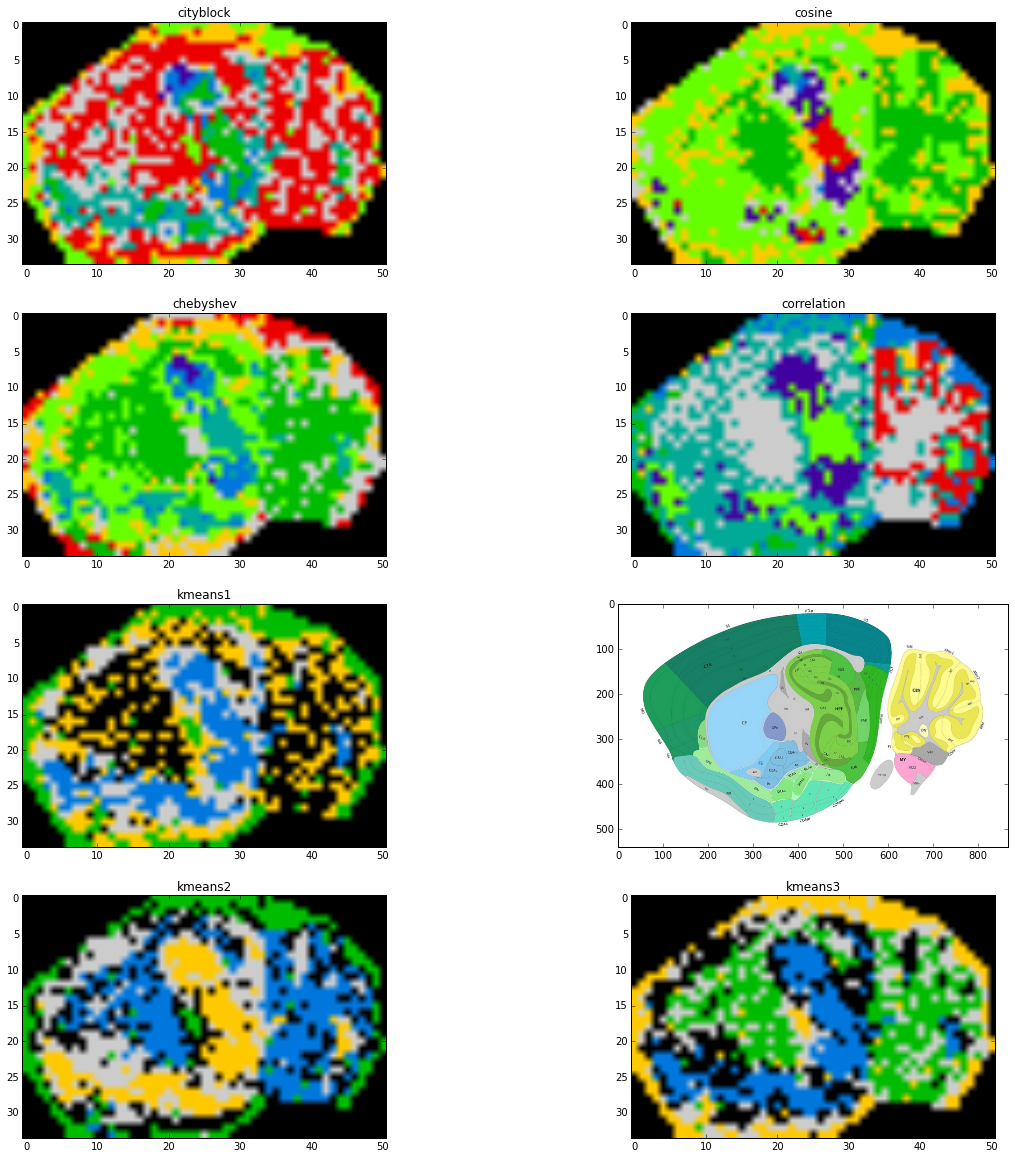

In [29]:
aant_cluster=8

#verschillende distance metrics: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
#Clustering
from scipy.spatial.distance import pdist

dist = pdist(data_na_AE, 'cityblock',p=2)
link= sch.linkage(dist,method='complete')
label = sch.fcluster(link, aant_cluster, 'maxclust')

dist2 = pdist(data_na_AE, 'cosine',p=2)
link2= sch.linkage(dist2,method='complete')
label2 = sch.fcluster(link2, aant_cluster, 'maxclust')

dist3 = pdist(data_na_AE, 'chebyshev',p=2)
link3= sch.linkage(dist3,method='complete')
label3 = sch.fcluster(link3, aant_cluster, 'maxclust')

dist4 = pdist(data_na_AE, 'correlation',p=2)
link4= sch.linkage(dist4,method='complete')
label4 = sch.fcluster(link4, aant_cluster, 'maxclust')



# plot dendrogram
#ct=link[-(aant_cluster-1),2]  
#P =sch.dendrogram(link,p=4, truncate_mode='level',no_labels='true',color_threshold=ct)
#plt.show()


#plot resultaat clustering

atlas=mpimg.imread('atlas.png')
img=get_label_img(label)
img2=get_label_img(label2)
img3=get_label_img(label3)
img4=get_label_img(label4)


fig2 = plt.figure(figsize = (20,20))
ax3 = fig2.add_subplot(421)
imgplot2=ax3.imshow(img, cmap='spectral')
ax3.set_title('cityblock')
ax4 = fig2.add_subplot(422)
imgplot2=ax4.imshow(img2, cmap='spectral')
ax4.set_title('cosine')
ax5 = fig2.add_subplot(423)
imgplot3=ax5.imshow(img3, cmap='spectral')
ax5.set_title('chebyshev')
ax6 = fig2.add_subplot(424)
imgplot1=ax6.imshow(img4, cmap='spectral')
ax6.set_title('correlation')



aant_cluster=5

from scipy.cluster.vq import kmeans2, vq

centroids5, label5 = kmeans2(data_na_AE, aant_cluster)
centroids6, label6 = kmeans2(data_na_AE, aant_cluster)
centroids7, label7 = kmeans2(data_na_AE, aant_cluster)

#plot resultaat clustering

atlas=mpimg.imread('atlas.png')
img5=get_label_img(label5)
img6=get_label_img(label6)
img7=get_label_img(label7)

 
ax7 = fig2.add_subplot(425)
imgplot1=ax7.imshow(img5, cmap='spectral')
ax7.set_title('kmeans1')
atl=fig2.add_subplot(426)
atl.imshow(atlas)
ax8 = fig2.add_subplot(427)
imgplot1=ax8.imshow(img6, cmap='spectral')
ax8.set_title('kmeans2')
ax9 = fig2.add_subplot(428)
imgplot1=ax9.imshow(img7, cmap='spectral')
ax9.set_title('kmeans3')




#plt.savefig('AE_N100C12_beter.pdf')

#plt.colorbar(imgplot1,fraction=0.03)
#atl=fig2.add_subplot(222)
#atl.imshow(atlas)

#plt.savefig('AE_dropping_w_6.pdf')


